In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from yellowbrick.features.importances import FeatureImportances

import datetime as dt
from scipy import stats
from scipy.stats import norm, skew

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold


from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, svm, gaussian_process
from sklearn.linear_model import ElasticNet, Lasso, LassoLars, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor

## Load Data

In [2]:
df_train = pd.read_csv("df_train.csv",encoding = "utf8") 
df_test = pd.read_csv("df_test.csv",encoding = "utf8") 

In [3]:
df_train=df_train[df_train.BROWSE_CNT>0]

In [4]:
df_train.NEXT_WM_APPLY.value_counts()

0.0    57289
1.0     1370
Name: NEXT_WM_APPLY, dtype: int64

In [5]:
df_train.info(),df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58659 entries, 5 to 187678
Columns: 156 entries, CUST_NO to CUST_YEAR_WM_P
dtypes: float64(153), int64(1), object(2)
memory usage: 70.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 156 entries, CUST_NO to CUST_YEAR_WM_P
dtypes: float64(153), int64(1), object(2)
memory usage: 35.7+ MB


(None, None)

In [6]:
CM_CUST=['CUST_NO', 'CUST_YEAR', 'D90_TXN_CNT',  # 'CUST_START_DT',
       'BROWSE_CNT','BROWSE_URL',
       'BROWSE_DATE_LAST_DAYS','BROWSE_DATE_FIRST_DAYS', 
       'PAGE_OFTEN_CAT_3','PAGE_OFTEN_CAT_5','PAGE_OFTEN_CAT_9','PAGE_OFTEN_CAT_11','PAGE_OFTEN_CAT_14','PAGE_OFTEN_CAT_19',
       'PAGE_OFTEN_CAT_21','PAGE_OFTEN_CAT_23','PAGE_OFTEN_CAT_25','PAGE_OFTEN_CAT_35','PAGE_OFTEN_CAT_69',
       'PAGE_OFTEN_CAT_135','PAGE_OFTEN_CAT_155','PAGE_OFTEN_CAT_177','PAGE_OFTEN_CAT_192','PAGE_OFTEN_CAT_196',
       'PAGE_OFTEN_CAT_210','PAGE_OFTEN_CAT_223', 'PAGE_OFTEN_CAT_252','PAGE_OFTEN_CAT_257','PAGE_OFTEN_CAT_259',
       'PAGE_OFTEN_CAT_261','PAGE_OFTEN_CAT_999',
       'GENDER_CODE_F', 'GENDER_CODE_M','GENDER_CODE_999','AGE_1', 'AGE_2','AGE_3', 'AGE_4', 
       'CHILDREN_CNT_0.0', 'CHILDREN_CNT_1.0','CHILDREN_CNT_2.0', 'CHILDREN_CNT_3.0', 'CHILDREN_CNT_4.0',
       'CHILDREN_CNT_5.0', 'CHILDREN_CNT_6.0', 'CHILDREN_CNT_9.0','CHILDREN_CNT_10.0', 'CHILDREN_CNT_999.0',
       'EDU_CODE_1.0', 'EDU_CODE_2.0', 'EDU_CODE_3.0','EDU_CODE_4.0', 'EDU_CODE_5.0', 'EDU_CODE_6.0', 'EDU_CODE_999.0',
       'INCOME_RANGE_CODE_1.0','INCOME_RANGE_CODE_2.0', 'INCOME_RANGE_CODE_3.0','INCOME_RANGE_CODE_4.0', 'INCOME_RANGE_CODE_999.0',
       'WORK_MTHS_1.0', 'WORK_MTHS_2.0','WORK_MTHS_3.0', 'WORK_MTHS_4.0', 'WORK_MTHS_5.0','WORK_MTHS_999.0',
       'GENDER_LN','AGE_LN','CHILDREN_LN','EDU_CODE_LN','INCOME_RANGE_LN','WORK_MTHS_LN',
       'GENDER_CC','AGE_CC','CHILDREN_CC','EDU_CODE_CC','INCOME_RANGE_CC','WORK_MTHS_CC',
       'GENDER_FX','AGE_FX','CHILDREN_FX','EDU_CODE_FX','INCOME_RANGE_FX','WORK_MTHS_FX',
       'GENDER_WM','AGE_WM','CHILDREN_WM','EDU_CODE_WM','INCOME_RANGE_WM','WORK_MTHS_WM']

In [7]:
CM_WM = ['D0_WM_LAST_DAYS','D90_WM_CNT',  
         'WM_DAY_INTERVAL_LAST','WM_DAY_INTERVAL_FIRST','WM_DAY_INTERVAL_AVG',   
         'D90_WM_AMT_SUM','D90_WM_AMT_MIN','D90_WM_AMT_MAX','D90_WM_AMT_STD','D90_WM_AMT_AVG',
         'D90_WM_CUST_RISK_CODE', 'D90_WM_CUST_INVEST_TYPE_CODE']

In [8]:
Y=df_train[['NEXT_WM_APPLY']].copy().fillna(0)

In [9]:
train=df_train[CM_CUST+CM_WM].copy()
test=df_test[CM_CUST+CM_WM].copy()

In [10]:
train=train.fillna(0)
test=test.fillna(0)

In [11]:
test[CM_CUST].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 89 columns):
CUST_NO                    30000 non-null object
CUST_YEAR                  30000 non-null float64
D90_TXN_CNT                30000 non-null float64
BROWSE_CNT                 30000 non-null float64
BROWSE_URL                 30000 non-null float64
BROWSE_DATE_LAST_DAYS      30000 non-null float64
BROWSE_DATE_FIRST_DAYS     30000 non-null float64
PAGE_OFTEN_CAT_3           30000 non-null float64
PAGE_OFTEN_CAT_5           30000 non-null float64
PAGE_OFTEN_CAT_9           30000 non-null float64
PAGE_OFTEN_CAT_11          30000 non-null float64
PAGE_OFTEN_CAT_14          30000 non-null float64
PAGE_OFTEN_CAT_19          30000 non-null float64
PAGE_OFTEN_CAT_21          30000 non-null float64
PAGE_OFTEN_CAT_23          30000 non-null float64
PAGE_OFTEN_CAT_25          30000 non-null float64
PAGE_OFTEN_CAT_35          30000 non-null float64
PAGE_OFTEN_CAT_69          30000 non-null 

In [12]:
train=train.drop(['CUST_NO'], axis=1)
test=test.drop(['CUST_NO'], axis=1)

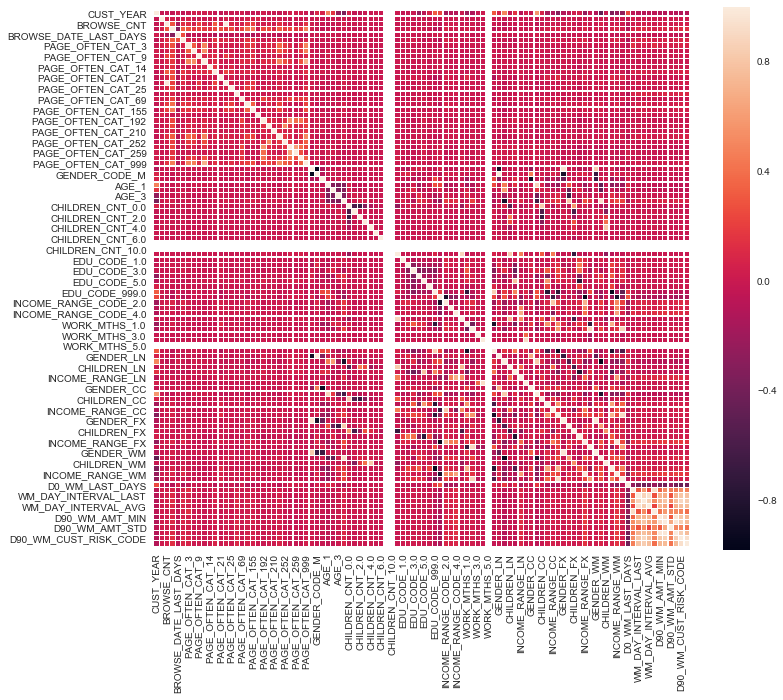

In [13]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, linewidths=0.1, vmax=1.0, square=True)

In [14]:
def correlation(col_corr, threshold):
    #col_corr = delcols#set() # Set of all the names of deleted columns
    corr_matrix = train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.append(colname)
                if colname in train.columns:
                    del train[colname] # deleting the column from the dataset
                if colname in test.columns:
                    del test[colname] # deleting the column from the dataset

    print(col_corr)
    delcols=col_corr
    #print(dataset)

In [15]:
delcols=[]
correlation(delcols,0.95)

['PAGE_OFTEN_CAT_23', 'GENDER_LN', 'GENDER_WM', 'INCOME_RANGE_WM', 'D90_WM_AMT_AVG', 'D90_WM_AMT_AVG']


In [16]:
kf=KFold(n_splits=5, random_state=42, shuffle=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train,Y, test_size=0.3, random_state=42)

In [18]:
lgbc = lgb.LGBMClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,rondom_state=42)
lgbc.fit(X_train, y_train,eval_metric='auc') 

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, rondom_state=42, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [19]:
print("R Square:",lgbc.score(X_test, y_test))
print("ROC AUC score:",metrics.roc_auc_score(y_test,lgbc.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,lgbc.predict(X_test)))
print("recall:",metrics.recall_score(y_test,lgbc.predict(X_test)))
print("precision:",metrics.precision_score(y_test,lgbc.predict(X_test)))

R Square: 0.9776679168087282
ROC AUC score: 0.9371323823865354
F1 Square: 0.18969072164948456
recall: 0.1141439205955335
precision: 0.5609756097560976


In [20]:
params = {'learning_rate':[0.1],'n_estimators':[100,200], 'max_depth':[3]}
gs_lgbc = GridSearchCV(estimator=lgbc, param_grid=params, cv=3, verbose=2, scoring='f1') 
gs_lgbc.fit(X_train, y_train, eval_metric='auc') 

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=3, n_estimators=100, total=   0.3s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=3, n_estimators=100, total=   0.3s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=3, n_estimators=100, total=   0.3s
[CV] learning_rate=0.1, max_depth=3, n_estimators=200 ................


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=3, n_estimators=200, total=   0.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=200 ................


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=3, n_estimators=200, total=   0.4s
[CV] learning_rate=0.1, max_depth=3, n_estimators=200 ................


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=3, n_estimators=200, total=   0.4s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s finished
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, rondom_state=42, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1], 'n_estimators': [100, 200], 'max_depth': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [21]:
gs_lgbc.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, rondom_state=42, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
print("R Square:",metrics.accuracy_score(y_test, gs_lgbc.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,gs_lgbc.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,gs_lgbc.predict(X_test)))
print("recall:",metrics.recall_score(y_test,gs_lgbc.predict(X_test)))
print("precision:",metrics.precision_score(y_test,gs_lgbc.predict(X_test)))

R Square: 0.9771564950562563
ROC AUC score: 0.9362903406192433
F1 Square: 0.19277108433734938
recall: 0.11910669975186104
precision: 0.5052631578947369


In [23]:
xgbc = xgb.XGBClassifier(learning_rate=0.1,max_depth=3, n_estimators=100,random_state=42, tree_method='gpu_hist')
xgbc.fit(X_train,y_train,eval_metric='auc')
#eval_set  = [(X_train , y_train) , (X_test , y_test)]
#xgbc.fit(X_train ,  y_train ,eval_set=eval_set,eval_metric='auc',early_stopping_rounds=20)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist')

In [24]:
print("R Square:",metrics.accuracy_score(y_test, xgbc.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,xgbc.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,xgbc.predict(X_test)))
print("recall:",metrics.recall_score(y_test,xgbc.predict(X_test)))
print("precision:",metrics.precision_score(y_test,xgbc.predict(X_test)))

R Square: 0.9776679168087282
ROC AUC score: 0.9398609729154055
F1 Square: 0.21556886227544908
recall: 0.13399503722084366
precision: 0.5510204081632653


In [25]:
params = {'learning_rate':[0.1],'n_estimators':[100,200]}
gs = GridSearchCV(estimator=xgbc, param_grid=params, cv=3,n_jobs=-1,verbose=1, scoring='f1') 
gs.fit(X_train, y_train,eval_metric='auc')

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    6.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.0s finished
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1], 'n_estimators': [100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [26]:
gs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist')

In [27]:
print("R Square:",metrics.accuracy_score(y_test, gs.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,gs.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,gs.predict(X_test)))
print("recall:",metrics.recall_score(y_test,gs.predict(X_test)))
print("precision:",metrics.precision_score(y_test,gs.predict(X_test)))

R Square: 0.9776679168087282
ROC AUC score: 0.9389785968423794
F1 Square: 0.23391812865497078
recall: 0.1488833746898263
precision: 0.5454545454545454


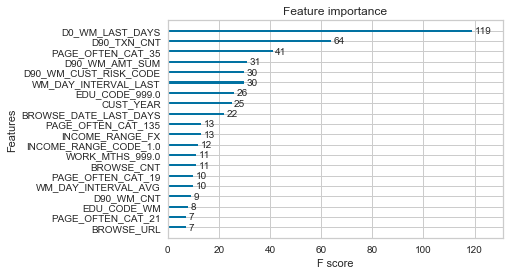

In [28]:
from xgboost import plot_importance
plot_importance(xgbc,max_num_features=20)
plt.show()

In [29]:
clf = RandomForestClassifier(n_estimators=100)
params = {'class_weight':[{0:1, 1:pos_weight} for pos_weight in np.arange(1, 2,1)]}
gs_rfx = GridSearchCV(estimator=clf, param_grid=params, cv=3, scoring='f1') 
gs_rfx.fit(X_train, y_train)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was pa

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'class_weight': [{0: 1, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [30]:
gs_rfx.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [31]:
print("R Square:",metrics.accuracy_score(y_test, gs_rfx.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,gs_rfx.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,gs_rfx.predict(X_test)))
print("recall:",metrics.recall_score(y_test,gs_rfx.predict(X_test)))
print("precision:",metrics.precision_score(y_test,gs_rfx.predict(X_test)))

R Square: 0.9773837936129106
ROC AUC score: 0.9124933888537337
F1 Square: 0.17768595041322313
recall: 0.10669975186104218
precision: 0.5308641975308642


In [32]:
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
X_test_std=sc.fit_transform(X_test)
test_std=sc.fit_transform(test)

In [33]:
lr= LogisticRegression(penalty='l1',C=1, random_state=42)
lr.fit(X_train_std, y_train)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
print("R Square:",lr.score(X_test_std, y_test))
print("ROC AUC score:",metrics.roc_auc_score(y_test,lr.predict_proba(X_test_std)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,lr.predict(X_test_std)))
print("recall:",metrics.recall_score(y_test,lr.predict(X_test_std)))
print("precision:",metrics.precision_score(y_test,lr.predict(X_test_std)))

R Square: 0.977326968973747
ROC AUC score: 0.9253594551477471
F1 Square: 0.22222222222222224
recall: 0.141439205955335
precision: 0.5181818181818182


In [35]:
from vecstack import stacking

In [36]:
X_train, X_test, y_train, y_test = train_test_split(train, Y, test_size=0.2, random_state=42)

In [37]:
# Initialize 1st level estimators
models = [gs.best_estimator_,gs_lgbc.best_estimator_,gs_rfx.best_estimator_,lr]

S_X_train, S_X_test = stacking(models, X_train, y_train, X_test, regression = False, 
                               metric = metrics.log_loss, n_folds = 4,needs_proba=True,stratified = True, shuffle = True, 
                               random_state = 42, verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [XGBClassifier]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    fold  0:  [0.07069504]
    fold  1:  [0.06978193]
    fold  2:  [0.06380649]
    fold  3:  [0.06857706]
    ----
    MEAN:     [0.06821513] + [0.00265386]
    FULL:     [0.06821512]

model  1:     [LGBMClassifier]
    fold  0:  [0.07186601]
    fold  1:  [0.07115220]
    fold  2:  [0.06444704]
    fold  3:  [0.07048530]
    ----
    MEAN:     [0.06948764] + [0.00295086]
    FULL:     [0.06948761]

model  2:     [RandomForestClassifier]
    fold  0:  [0.12080916]
    fold  1:  [0.12415364]
    fold  2:  [0.09945580]
    fold  3:  [0.10533241]
    ----
    MEAN:     [0.11243775] + [0.01032424]
    FULL:     [0.11243791]

model  3:     [LogisticRegression]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  0:  [0.07365462]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  1:  [0.07274709]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  2:  [0.06769216]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  3:  [0.07485117]
    ----
    MEAN:     [0.07223626] + [0.00272760]
    FULL:     [0.07223620]



In [38]:
S_X_train.shape,S_X_test.shape,

((46927, 8), (11732, 8))

In [39]:
# Initialize 2nd level model
model = LogisticRegression(penalty='l1',C=1, random_state=42)
    
# Fit 2nd level model
model = model.fit(S_X_train, y_train)

# Predict
y_pred = model.predict(S_X_test)
y_pred_proba = model.predict_proba(S_X_test)[:,1]

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
print("R Square:",metrics.accuracy_score(y_test, model.predict(S_X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,model.predict_proba(S_X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,model.predict(S_X_test)))
print("recall:",metrics.recall_score(y_test,model.predict(S_X_test)))
print("precision:",metrics.precision_score(y_test,model.predict(S_X_test)))

R Square: 0.9766450733037845
ROC AUC score: 0.9322408690201306
F1 Square: 0.26344086021505375
recall: 0.1781818181818182
precision: 0.5051546391752577


In [41]:
y_pred.sum(),y_pred_proba.sum()

(97.0, 272.57851909883084)

In [42]:
predict_stack = pd.DataFrame(y_pred_proba, columns=['WM_IND_P'])

In [54]:
# Use trial and error, found 0.148 is the best threshold to max F1-score
predict_stack['WM_IND']=np.where(predict_stack.WM_IND_P>0.148,1,0)
predict_stack['WM_IND'].value_counts()

0    11469
1      263
Name: WM_IND, dtype: int64

In [55]:
# find max F1-score is 0.420 > default threshold F1-score 0.263
print("R Square:",metrics.accuracy_score(y_test, predict_stack['WM_IND']))
print("ROC AUC score:",metrics.roc_auc_score(y_test,predict_stack['WM_IND_P']))
print("F1 Square:",metrics.f1_score(y_test,predict_stack['WM_IND']))
print("recall:",metrics.recall_score(y_test,predict_stack['WM_IND']))
print("precision:",metrics.precision_score(y_test,predict_stack['WM_IND']))

R Square: 0.9734060688714626
ROC AUC score: 0.9322408690201306
F1 Square: 0.42007434944237915
recall: 0.4109090909090909
precision: 0.4296577946768061


In [45]:
# Initialize 1st level estimators
models = [gs.best_estimator_,gs_lgbc.best_estimator_,gs_rfx.best_estimator_,lr]

S_train, S_test = stacking(models, train, Y, test, regression = False, 
                               metric = metrics.log_loss, n_folds = 4,needs_proba=True,stratified = True, shuffle = True, 
                               random_state = 42, verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [XGBClassifier]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    fold  0:  [0.06458222]
    fold  1:  [0.06922102]
    fold  2:  [0.06787448]
    fold  3:  [0.06948560]
    ----
    MEAN:     [0.06779083] + [0.00195063]
    FULL:     [0.06779074]

model  1:     [LGBMClassifier]
    fold  0:  [0.06545007]
    fold  1:  [0.06983434]
    fold  2:  [0.06908590]
    fold  3:  [0.07027929]
    ----
    MEAN:     [0.06866240] + [0.00190303]
    FULL:     [0.06866231]

model  2:     [RandomForestClassifier]
    fold  0:  [0.10481678]
    fold  1:  [0.10914983]
    fold  2:  [0.11823698]
    fold  3:  [0.12441675]
    ----
    MEAN:     [0.11415509] + [0.00765213]
    FULL:     [0.11415468]

model  3:     [LogisticRegression]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  0:  [0.06813438]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  1:  [0.07287848]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  2:  [0.07272586]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  3:  [0.07486270]
    ----
    MEAN:     [0.07215035] + [0.00246710]
    FULL:     [0.07215023]



In [46]:
# Initialize 2nd level model
model2 = LogisticRegression(penalty='l1',C=1, random_state=42)
    
# Fit 2nd level model
model2 = model2.fit(S_train, Y)

# Predict
y_pred2 = model2.predict(S_test)
y_pred2_proba = model2.predict_proba(S_test)[:,1]

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
y_pred2.sum(),y_pred2_proba.sum()

(158.0, 642.4667208166175)

In [48]:
predict_stack2 = pd.DataFrame(y_pred2_proba, columns=['WM_IND_P'])

In [56]:
predict_stack2['WM_IND']=np.where(predict_stack2.WM_IND_P>0.148,1,0)
predict_stack2['WM_IND'].value_counts()

0    29560
1      440
Name: WM_IND, dtype: int64

In [57]:
predict_stack2.to_csv('WM_result.csv', index=False)